# Ada Boost

- Tạo ra cây Strump có độ sâu = 1
- Chọn 1 feature tốt nhất
- Học dựa trên lỗi sai
- Khuếch đại feature sai lên để tăng xác xuất từ các lần trước đó
- Lấy kết quả sai số từ lần huấn luyện n-1 để làm bộ dữ liệu mới trong lần huấn luyên thứ n.
- Các lần huấn luyện dựa trên cùng 1 loại giải thuật

In [1]:
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn import tree
import matplotlib.pyplot as plt
import pandas as pd

# load data
data = pd.read_csv('../source/iris_2D(1).csv')

# get x
x_data = data[['Petal_Length', 'Petal_Width']].to_numpy()
x_data = x_data.reshape(6, 2)
print(x_data)

[[1.  0.2]
 [1.3 0.6]
 [0.9 0.7]
 [1.7 0.5]
 [1.8 0.9]
 [1.2 1.3]]


In [2]:
y_train = np.array([0, 0, 0, 1, 1, 1]) 
print(y_train)

[0 0 0 1 1 1]


In [3]:
dt_classifier = AdaBoostClassifier(n_estimators=3, 
                                   random_state=0)
dt_classifier.fit(x_data, y_train)

c:\Users\vanna\.conda\envs\.env\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(n_estimators=3, random_state=0)

In [4]:
dt_classifier.predict(np.array([[2.7, 0.8]]))

array([1])

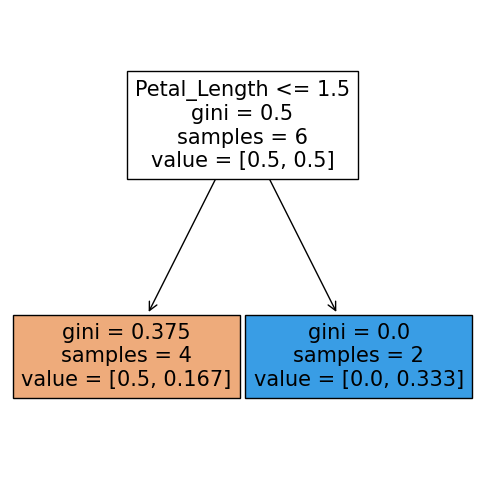

In [5]:
plt.figure(figsize=(6,6))
_ = tree.plot_tree(dt_classifier.estimators_[0], 
                   feature_names=['Petal_Length', 'Petal_Width'], 
                   filled=True)

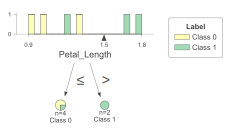

In [6]:
import dtreeviz

viz_model = dtreeviz.model(dt_classifier.estimators_[0],
                           X_train=x_data, y_train=y_train,
                           feature_names=['Petal_Length', 'Petal_Width'],
                           target_name='Label')

viz_model.view()

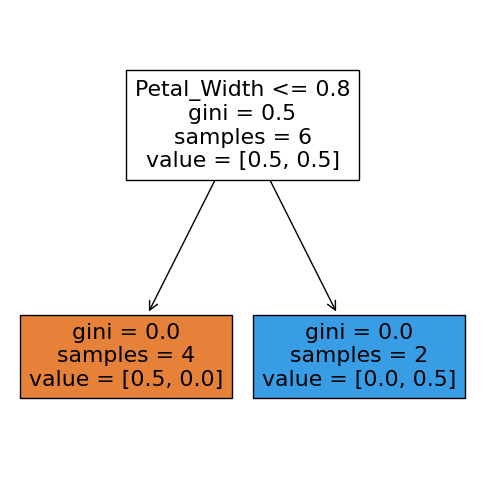

In [7]:
plt.figure(figsize=(6,6))
_ = tree.plot_tree(dt_classifier.estimators_[1], 
                   feature_names=['Petal_Length', 'Petal_Width'], 
                   filled=True)

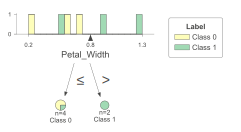

In [8]:
import dtreeviz

viz_model = dtreeviz.model(dt_classifier.estimators_[1],
                           X_train=x_data, y_train=y_train,
                           feature_names=['Petal_Length', 'Petal_Width'],
                           target_name='Label')

viz_model.view()

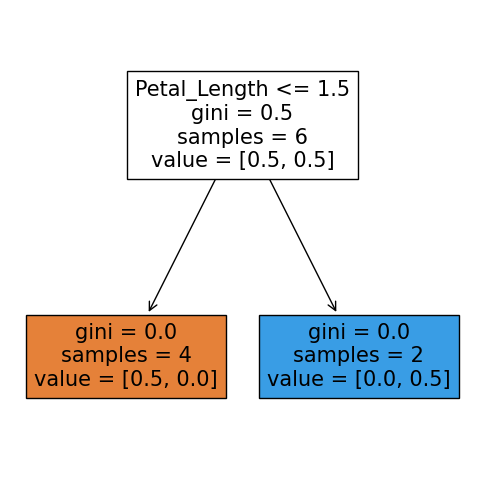

In [9]:
plt.figure(figsize=(6,6))
_ = tree.plot_tree(dt_classifier.estimators_[2], 
                   feature_names=['Petal_Length', 'Petal_Width'], 
                   filled=True)

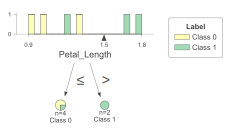

In [10]:
import dtreeviz

viz_model = dtreeviz.model(dt_classifier.estimators_[2],
                           X_train=x_data, y_train=y_train,
                           feature_names=['Petal_Length', 'Petal_Width'],
                           target_name='Label')

viz_model.view()

## Theory

In [11]:

# Imports
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier

# Helper functions
def compute_error(y, y_pred, w_i):
    '''
    Calculate the error rate of a weak classifier m. Arguments:
    y: actual target value
    y_pred: predicted value by weak classifier
    w_i: individual weights for each observation


    Note that all arrays should be the same length
    '''

    return (sum(w_i * (np.not_equal(y, y_pred)).astype(int)))/sum(w_i)

def compute_alpha(error):
    '''
    Calculate the weight of a weak classifier m in the majority vote of the final classifier. This is called
    alpha in chapter 10.1 of The Elements of Statistical Learning. Arguments:
    error: error rate from weak classifier m
    '''
    espilon = 0.01
    return np.log((1 - error + espilon) / (error+espilon))

def update_weights_formular1(w_i, alpha, y, y_pred):
    result = w_i * np.exp(-alpha * y * y_pred)
    w_norm = result / np.sum(result)
    return w_norm


def update_weights_formular2(w_i, alpha, y, y_pred):
    result = w_i * np.exp(alpha * (
        np.not_equal(y, y_pred)).astype(int))
    w_norm = result / np.sum(result)
    return w_norm


# Define AdaBoost class
class AIVNAdaBoost:

    def __init__(self):
        # self.w_i = None
        self.alphas = []
        self.G_M = []
        self.M = None
        self.training_errors = []
        self.prediction_errors = []

    def fit(self, X, y, M = 100):
        '''
        Fit model. Arguments:
        X: independent variables
        y: target variable
        M: number of boosting rounds. Default is 100
        '''

        # Clear before calling
        self.alphas = []
        self.training_errors = []
        self.M = M

        # Iterate over M weak classifiers
        for m in range(0, M):

            # Set weights for current boosting iteration
            if m == 0:
                w_i = np.ones(len(y)) * 1 / len(y)  # At m = 0, weights are all the same and equal to 1 / N
            else:
                 w_i = update_weights_formular2(w_i, alpha_m, y, y_pred)
                # w_i = update_weights_formular1(w_i, alpha_m, y, y_pred)
            # print(w_i)

            # (a) Fit weak classifier and predict labels
            G_m = DecisionTreeClassifier(max_depth = 1)     # Stump: Two terminal-node classification tree
            G_m.fit(X, y, sample_weight = w_i)
            y_pred = G_m.predict(X)

            self.G_M.append(G_m) # Save to list of weak classifiers

            # (b) Compute error
            error_m = compute_error(y, y_pred, w_i)
            self.training_errors.append(error_m)
            # print(error_m)

            # (c) Compute alpha
            alpha_m = compute_alpha(error_m)
            self.alphas.append(alpha_m)
            # print(alpha_m)

        assert len(self.G_M) == len(self.alphas)


    def predict(self, X):
        '''
        Predict using fitted model. Arguments:
        X: independent variables
        '''

        # Initialise dataframe with weak predictions for each observation
        weak_preds = pd.DataFrame(index = range(len(X)), columns = range(self.M))

        # Predict class label for each weak classifier, weighted by alpha_m
        for m in range(self.M):
            y_pred_m = self.G_M[m].predict(X) * self.alphas[m]
            #weak_preds.iloc[:,m] = y_pred_m
            weak_preds[weak_preds.columns[m]] = y_pred_m

        # Estimate final predictions
        y_pred = (1 * np.sign(weak_preds.T.sum())).astype(int)

        return y_pred

    def error_rates(self, X, y):
        '''
        Get the error rates of each weak classifier. Arguments:
        X: independent variables
        y: target variables associated to X
        '''

        self.prediction_errors = [] # Clear before calling

        # Predict class label for each weak classifier
        for m in range(self.M):
            y_pred_m = self.G_M[m].predict(X)
            error_m = compute_error(y = y, y_pred = y_pred_m, w_i = np.ones(len(y)))
            self.prediction_errors.append(error_m)

In [12]:
result = [0.07, 0.07, 0.07, 0.22, 0.07, 0.07, 0.07, 0.22]
w_norm = result / np.sum(result)
print(w_norm)

[0.08139535 0.08139535 0.08139535 0.25581395 0.08139535 0.08139535
 0.08139535 0.25581395]


In [13]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier

In [14]:
#Prepare dataset
X, y = make_classification(n_samples= 1000, n_features = 20, random_state = 42)
y = y * 2 - 1       # Original AdaBoost uses {1, -1} as class labels

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [17]:
#Prepare spam dataset

df = pd.read_csv('../source/spambase.data', header = None)
names = pd.read_csv('../source/spambase.names', sep = ':', skiprows=range(0, 33), header = None)
col_names = list(names[0])
col_names.append('Spam')
df.columns = col_names
df.head()

df['Spam'] = df['Spam'] * 2 - 1

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = 'Spam').values, df['Spam'].values, test_size = 0.2, random_state = 2)




In [18]:
# Fit model
ab = AIVNAdaBoost()
ab.fit(X_train, y_train, M = 50)

# Predict on test set
y_pred = ab.predict(X_test)
print('The accuracy_score of the model is:', round(accuracy_score(y_test, y_pred), 4))

The accuracy_score of the model is: 0.9349


## Using the Library Scikit-Learn implementation of AdaBoost

In [19]:
from sklearn.ensemble import AdaBoostClassifier

ab_sk = AdaBoostClassifier(n_estimators = 50)
ab_sk.fit(X_train, y_train)
y_pred_sk = ab_sk.predict(X_test)
print('The accuracy_score of the model is:', round(accuracy_score(y_test, y_pred_sk), 4))

c:\Users\vanna\.conda\envs\.env\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.


The accuracy_score of the model is: 0.9435
